In [1]:
import os
from pathlib import Path

from osgeo import gdal
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer

In [2]:
import s3fs

fs = s3fs.S3FileSystem(anon=True)

s3_path = 'noaa-urma-pds'

dates = sorted(fs.glob(s3_path + '/ak*'))
print(f"There are {len(dates)} days accessible, ranging from {min(dates).split('.')[-1]} to {max(dates).split('.')[-1]}")

There are 3472 days accessible, ranging from 20160106 to 20250708


In [3]:
hourly_files = fs.ls(dates[0])

In [4]:
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"
gdal.UseExceptions()

ds = gdal.Open('/vsis3/' + hourly_files[0])

print("Driver:", ds.GetDriver().ShortName)
print("Size:", ds.RasterXSize, ds.RasterYSize)
print()
for i in range(1, ds.RasterCount + 1):
    band = ds.GetRasterBand(i)
    print(f"Band {i}: {band.GetMetadata()['GRIB_COMMENT']}")


Driver: GRIB
Size: 1649 1105

Band 1: Geopotential height [gpm]
Band 2: Pressure [Pa]
Band 3: Temperature [C]
Band 4: Dew point temperature [C]
Band 5: u-component of wind [m/s]
Band 6: v-component of wind [m/s]
Band 7: Specific humidity [kg/kg]
Band 8: Wind direction (from which blowing) [deg true]
Band 9: Wind speed [m/s]
Band 10: Wind speed (gust) [m/s]
Band 11: Visibility [m]


In [5]:
from pyproj import CRS, Transformer

def transform_to_ds(x,y):
    
    proj_wkt = ds.GetProjection()
    gt = ds.GetGeoTransform()
    crs_ds = CRS.from_wkt(proj_wkt)

    crs_wgs84 = CRS.from_epsg(4326)

    transformer = Transformer.from_crs(crs_wgs84, crs_ds, always_xy=True)

    x_geo, y_geo = transformer.transform(y, x)

    px = int((x_geo - gt[0]) / gt[1])
    py = int((y_geo - gt[3]) / gt[5])
    
    return (px, py)



In [6]:
px, py = transform_to_ds(64.8, -147)

band = ds.GetRasterBand(3)
value = band.ReadAsArray(px, py, 1, 1)[0, 0]

print("Value at (x, y):", value)

Value at (x, y): -5.030004882812477


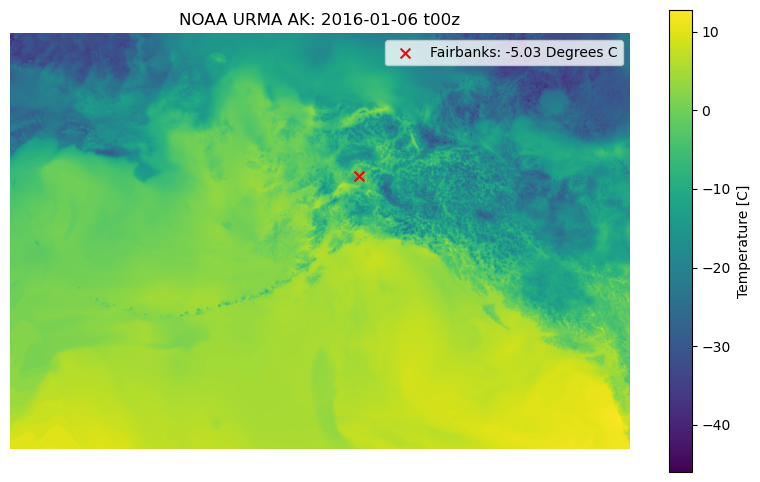

In [12]:
band = ds.GetRasterBand(3)
data = band.ReadAsArray()


plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='viridis')
plt.colorbar(label=band.GetMetadata()['GRIB_COMMENT'])
plt.scatter(px, py, color='red', marker='x', s=50, label=f'Fairbanks: {value.round(2)} Degrees C')
plt.title("NOAA URMA AK: 2016-01-06 t00z")
plt.axis('off')
plt.legend()
plt.show()